# Neural nets with Back-Propagation, this time with Pytorch

This notebook contains a complete implementation of a neural network this time implemented with Pytorch. 

I advise you to work through the notebook first, and seek to understand the code.  After that, go back to the places where I suggest activities, and try to implement these. 

AFTER GOING THROUGH THIS NOTEBOOK you will be ready to go to the textbooks by Smola or Howard, and work through the slightly more complicated implementations there.  (We will be doing MNIST and MNIST Fashion next week...) 

### Aims of this session: 

*  To understand how to implement a simple neural network in Pytorch 

*  To explore the structure of the Pytorch model, and examine the weights and the initialisation

*  To explore many more variations of the network using Pytorch to greatly speed things up


In [20]:
import numpy as np
import torch

In [21]:
import matplotlib.pyplot as plt
# the next instruction makes the plots appear within the notebook
%matplotlib inline

First we want some data.

Our data will be points in the plane. We will generate random points within a square, like so:  

In [22]:
X = 2 * np.random.random((100,2)) - 1

# you can re-run with more or fewer than 200 training data points 

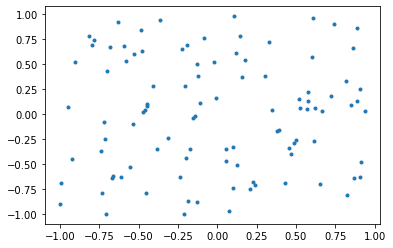

In [23]:
plt.plot(X[:,0],X[:,1],'.')

In [24]:
def classifier2(X):
    return (np.sum( X * X, axis=1) < 0.66 ).astype(float)

In [25]:
def classifier3(X): # a 3x2 checkerboard pattern
    return (( np.ceil((3/2)*(X[:,0]+1)).astype(int) + np.ceil( X[:,1]+1).astype(int) ) %2).astype(float)

In [26]:
def classifier4(X): # a 4x4 checkerboard pattern -- you can use the same method to make up your own checkerboard patterns
    return (np.sum( np.ceil( 2 * X).astype(int), axis=1 ) % 2).astype(float)

In [27]:
Y = classifier3( X ) 

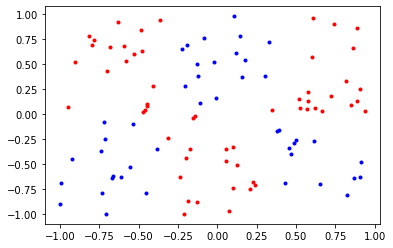

In [28]:
plt.plot(X[Y==0.0,0],X[Y==0.0,1],'b.')
plt.plot(X[Y==1.0,0],X[Y==1.0,1],'r.')

In [29]:
X.shape

(100, 2)

In [30]:
Y.shape

(100,)

# Doing it with Pytorch

Last week's program was a little painful: we had to construct the neural network and all of the gradients ourselves, and then check them. 

Is there an easier way? After all, many people have built neural networks before. 


In [2]:
import torch
import torch.nn as nn  # various types of layers
import torch.nn.functional as F  # activation functions, among other things

In [11]:
class Net1( nn.Module ): 
    
    def __init__(self):
        super(Net1,self).__init__()
        self.layer1 = nn.Linear(2,24)
        self.layer2 = nn.Linear(24,1) # these automatically define the weights and biases for the layers
        
    def forward(self,x):
        x = torch.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x 

In [12]:
net1 = Net1()
print( net1 )

Net1(
  (layer1): Linear(in_features=2, out_features=24, bias=True)
  (layer2): Linear(in_features=24, out_features=1, bias=True)
)


In [13]:
net1.parameters()

<generator object Module.parameters at 0x0000016635D97270>

In [14]:
list( net1.parameters() )

[Parameter containing:
 tensor([[ 0.6712, -0.0378],
         [-0.2130,  0.5227],
         [ 0.5424,  0.0640],
         [-0.4445, -0.2502],
         [ 0.0709,  0.0419],
         [-0.0986, -0.5304],
         [ 0.0335, -0.3458],
         [-0.0539,  0.0782],
         [ 0.6588, -0.2951],
         [ 0.5467,  0.2379],
         [-0.3221, -0.4409],
         [-0.4262,  0.4549],
         [-0.5560,  0.6941],
         [-0.4680, -0.1833],
         [ 0.2655,  0.5484],
         [-0.0149, -0.3152],
         [-0.0132, -0.1279],
         [-0.1691, -0.3298],
         [ 0.2519,  0.2939],
         [-0.3418,  0.5011],
         [ 0.3798,  0.3033],
         [-0.5584,  0.1530],
         [ 0.6620, -0.6774],
         [ 0.2556,  0.0548]], requires_grad=True),
 Parameter containing:
 tensor([-0.1549,  0.5465,  0.2704, -0.1667, -0.0658, -0.0321,  0.3087, -0.0278,
         -0.6722,  0.2140,  0.6592, -0.0148,  0.4160,  0.3238,  0.3647,  0.5528,
         -0.4822,  0.0327, -0.3875, -0.3832,  0.2417, -0.0172, -0.5243,  0

That's it! That is our feedforward specification of our previous NN2layer model!
All of the back-propagation will by compiled implicitly. 

In [38]:
X_tensor = torch.FloatTensor(X) # X is a double in numpy, we need float32
X_tensor.dtype

In [41]:
Y_tensor = torch.FloatTensor(Y)
Y_tensor.dtype

torch.float32

In [72]:
net1.zero_grad() # zero any gradients before doing forward pass 
output = net1(X_tensor)
output.shape

torch.Size([100, 1])

In [46]:
loss = nn.BCELoss()

In [62]:
output.shape

torch.Size([100, 1])

The target values (Y) need to be the same shape as the output before we compute the average loss (this is why one needs to be careful about always knowing the shape of one's tensors). Let's reshape Y to be like the output, therefore. 

In [59]:
Y_like_output = Y_tensor.reshape([100,1])
Y_like_output.shape

torch.Size([100, 1])

In [73]:
average_loss = loss( output, Y_like_output)
average_loss 

tensor(0.6745, grad_fn=<BinaryCrossEntropyBackward>)

In [74]:
average_loss.backward()

Now what do we do with the gradients?  Instead of writing our own code to update the weights by gradient descent, we will use an Optimizer object, one of the ones provided by pytorch. RMSProp is a nice, stable choice.  

This will take the parameters, with their attached gradients which have been calculated after `average_loss.backward()`, and then update the weights (sensibly) in the direction of the gradient. 

Let us first create the optimizer object.

In [69]:
optimizer = torch.optim.RMSprop( net1.parameters() )

In [75]:
# now actually use the optimizer to update the weights
optimizer.step()
# that's it - the weights have been adjusted! We can train again... 


Well, we have just written our neural net, cell by cell. Let's gather all the code together, into two phases: setup and training. 

### Setting up the net

In [86]:
# this defines our network as a subclass of nn.Module 

class Net1( nn.Module ): 
    
    def __init__(self):
        super(Net1,self).__init__()
        self.layer1 = nn.Linear(2,24)
        self.layer2 = nn.Linear(24,1) # these automatically define the weights and biases for the layers
        
    def forward(self,x):
        x = torch.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x 

In [87]:
# this creates a new instance of our neural network class
# it is initialised with random weights, and it needs training

net1 = Net1()
print( net1 )

Net1(
  (layer1): Linear(in_features=2, out_features=24, bias=True)
  (layer2): Linear(in_features=24, out_features=1, bias=True)
)


In [88]:
# we also need to specify the loss function we will use 
# In this case, binary cross-entropy (suitable for 2 class classifaction using
# the output of a sigmoid layer). 

loss_function = nn.BCELoss()

In [89]:
# In order to train it, we construct an instance of an optimizer class 
# which contains our network's parameters (given as a generator)

optimizer = torch.optim.RMSprop( net1.parameters() )

### Training the net

 Our training data is `X_tensor` (the inputs) and `Y_like_outpu`t ( the target classifications that we want our network to achieve).
 
 We reshaped `Y_like_output` to have the same shape as the output of our network (a little trial and error there...) 

In [90]:
n_epochs = 20

In [120]:
for i in range(0,n_epochs): 

    net1.zero_grad() # zero all gradients in the network
    # before doing back-propagation
    # It is important to remember to zero the gradients, 
    # otherwise the gradients will 
    # just accumulate. 
    
    output = net1( X_tensor )
    
    average_loss = loss_function( output, Y_like_output)
    
    print(i, average_loss.item()) # important to see what is happening
    # average_loss is a zero-dimensional tensor; to convert it to a number 
    # we cannot index, but instead we do average_loss.item() 
    
    average_loss.backward() # this computes all our gradients :) 
    
    optimizer.step() # this updates the weights :) 

0 0.05875313654541969
1 0.05846165120601654
2 0.058308277279138565
3 0.05805863067507744
4 0.057751189917325974
5 0.05749266594648361
6 0.05718951299786568
7 0.056875552982091904
8 0.05666082352399826
9 0.05636802688241005
10 0.05618526414036751
11 0.05594940111041069
12 0.05562141537666321
13 0.055344581604003906
14 0.05511494725942612
15 0.05484359711408615
16 0.05459995195269585
17 0.054469332098960876
18 0.05430332198739052
19 0.053959015756845474


In [106]:
def plot_nn_predictions( net1 ):
    x_values = np.linspace(-1,1,200)
    y_values = np.linspace(-1,1,200)
    
# challenge: this function is rather slow because the  model is being used to make one prediction at a time. 
# This incurs quite a large overhead: it is more efficient to make many predictions at once. Can you modify this 
# function to do this? 

# Now, can you rewrite the function so that you put in the whole grid of points as an input array to kerasmodel.predict(), 
# so that you only make one call net1 ? (This is an exercise in figuring out 
# the shapes of your tensors, and converting a torch tensor to a numpy array
# that matplotlib can use)

    J_grid = np.zeros([x_values.size,y_values.size])
    
    
    # We do something interesting here.  
    # We are not By calling torch.no_grad() 
    # we prevent pytorch from 
    with torch.no_grad(): 
        for x_index in range(0, x_values.size):
            for y_index in range(0, y_values.size):
                predicted_y_tensor =net1(torch.FloatTensor([x_values[x_index], y_values[y_index]]))
                J_grid[x_index,y_index] = predicted_y_tensor.item()
        
    plt.imshow(J_grid.transpose(), origin='lower',extent=[-1,1,-1,1])
    plt.colorbar()                                               

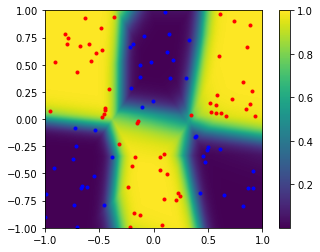

In [121]:
plot_nn_predictions(net1)

plt.plot(X[Y==0.0,0],X[Y==0.0,1],'b.')
plt.plot(X[Y==1.0,0],X[Y==1.0,1],'r.')

Exercise: do a 3D plot? That would be fun...

### How can we examine the weights and the gradients? 

Simple !  We can extract them from the neural network. 

Our network `net1` has two inputs, 24 neurons in the first layer, and 1 neuron in the output layer. 

The first layer is called `layer1` and the second `layer2` (go back and look at the definition of the class `Net1`)

In [122]:
net1.layer1

Linear(in_features=2, out_features=24, bias=True)

In [124]:
net1.layer1.weight

Parameter containing:
tensor([[ 0.5096, -0.1250],
        [ 3.7675, -2.1211],
        [-0.0406,  0.4999],
        [-0.0639,  0.7789],
        [-3.5117,  2.4813],
        [-2.0918,  1.6753],
        [-0.0747,  0.9027],
        [-0.2685, -0.0373],
        [-3.1776, -1.9659],
        [ 0.3369, -0.3208],
        [ 0.6030, -1.8530],
        [ 4.1451,  1.4651],
        [-0.1114,  1.4126],
        [-0.4070,  0.0733],
        [ 0.1043, -0.2804],
        [-2.7007,  2.6636],
        [-2.0128,  2.0280],
        [-3.1697, -1.9690],
        [-0.2269,  0.0944],
        [-0.0282, -2.9291],
        [-3.2707, -2.0125],
        [ 0.0220, -2.6449],
        [-4.6015, -2.8669],
        [-3.7558,  2.6513]], requires_grad=True)

In [128]:
# a small complication here. We want to convert the weight tensor to 
# a numpy array, but it has gradients attached. If requires_gradient is True, 
# we must use .detach().numpy() instead of just .numpy()

layer1_weights = net1.layer1.weight.detach().numpy()
layer1_weights

array([[ 0.50956136, -0.1249634 ],
       [ 3.7674859 , -2.1210942 ],
       [-0.04057133,  0.49994832],
       [-0.06386025,  0.778899  ],
       [-3.511651  ,  2.4813027 ],
       [-2.0918016 ,  1.6752733 ],
       [-0.07468221,  0.9026999 ],
       [-0.2684856 , -0.03727789],
       [-3.177579  , -1.9659224 ],
       [ 0.3368976 , -0.32080573],
       [ 0.60300946, -1.8530098 ],
       [ 4.1451106 ,  1.4651147 ],
       [-0.11136021,  1.4126244 ],
       [-0.40697005,  0.07333457],
       [ 0.10427511, -0.28044492],
       [-2.700681  ,  2.6635535 ],
       [-2.0127587 ,  2.027983  ],
       [-3.1697178 , -1.9690282 ],
       [-0.22686198,  0.09441966],
       [-0.02822177, -2.9291253 ],
       [-3.2707183 , -2.0124528 ],
       [ 0.02196269, -2.6449463 ],
       [-4.6014714 , -2.8668642 ],
       [-3.7558024 ,  2.6513252 ]], dtype=float32)

In [138]:
# we don't need to use detach for the gradients because the gradients are a 
# pure tensor. 

layer1_gradients = net1.layer1.weight.grad.numpy()
layer1_gradients

array([[ 0.0000000e+00,  0.0000000e+00],
       [-1.6965461e-04, -1.4525960e-03],
       [ 7.9836740e-05,  2.5116955e-05],
       [ 2.6137580e-04, -1.3714517e-04],
       [ 6.1362726e-03, -2.0306210e-03],
       [-1.2462145e-03, -2.1953043e-04],
       [ 1.7279403e-04,  2.9815834e-05],
       [ 0.0000000e+00,  0.0000000e+00],
       [-3.1840312e-03, -1.9106120e-03],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 7.8731508e-04,  5.9226179e-04],
       [-5.4780329e-03,  1.2385496e-04],
       [ 3.8870279e-04,  6.7071174e-05],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00],
       [-1.4111552e-03, -2.3885176e-04],
       [-1.3048410e-03,  8.0088386e-05],
       [-3.5966965e-03, -1.7658003e-03],
       [ 0.0000000e+00,  0.0000000e+00],
       [-6.7086681e-04, -4.1316159e-04],
       [-3.0244556e-03, -1.8148582e-03],
       [ 1.5667472e-03,  5.5009252e-03],
       [ 6.1765439e-03,  3.1174331e-03],
       [ 5.9669139e-03, -1.9745769e-03]], dtype=float32)

(array([ 3.,  8.,  6., 17.,  7.,  5.,  2.]),
 array([-4.6014714 , -3.3519597 , -2.102448  , -0.85293627,  0.39657545,
         1.6460872 ,  2.895599  ,  4.1451106 ], dtype=float32),
 <BarContainer object of 7 artists>)

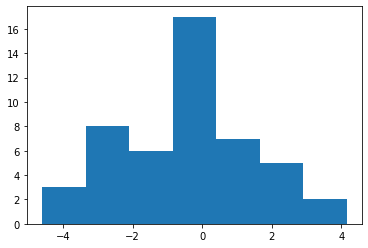

In [132]:
n_bins = 7
plt.hist( layer1_weights.reshape(-1), n_bins )

(array([ 1.,  3., 10., 28.,  1.,  1.,  4.]),
 array([-0.00547803, -0.00381309, -0.00214815, -0.00048321,  0.00118173,
         0.00284666,  0.0045116 ,  0.00617654], dtype=float32),
 <BarContainer object of 7 artists>)

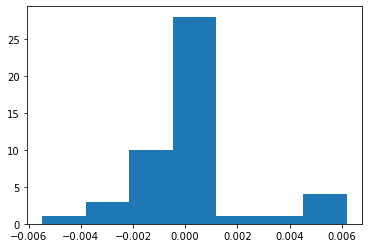

In [139]:
n_bins = 7 
plt.hist( layer1_gradients.reshape(-1), n_bins )

# More exercises: vary the network and explore the effects

Your task in this lab is to explore as many variations as possible using Keras. 

Try adding more layers, with larger numbers of neurons. What happens? 

Try using different types of activation function. What is the effect of, say, tanh or sigmoid as opposed to relu?  

Try using more data, with more complicated definitions of y (in particular, try using classifier4, or make up your own)

Plot the statistics on training and validation loss and accuracy, obtained from history.history

Compare the rates of learning of different network architectures. 